<a href="https://colab.research.google.com/github/fatemafaria142/English-Conversational-Abstractive-Summary-Generation-using-Pretrained-Transformer-Models/blob/main/English_Conversational_Abstractive_Summary_Generation_using_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.util import ngrams

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [ ]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.0 MB/s eta 0:00:00


# **Loading datastet from huggingface**
* Dataset link: https://huggingface.co/datasets/samsum?row=34

In [ ]:
from datasets import load_dataset

dataset = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [ ]:
data = pd.DataFrame({
    'text': dataset['train']['dialogue'],
    'summary':dataset['train']['summary']
})

In [ ]:
data.head()

,text,summary
0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...
1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...
2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...
3,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...
4,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com..."


# **Data Preprocessing**

In [ ]:
def preprocess_bangla_text(text):
    # Remove website links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove email links
    text = re.sub(r'\S+@\S+', '', text)

    # Remove specified punctuation
    punctuation = r'!#$%&\()*+-./:;?@[\]^_`{|}~'
    text = re.sub('[' + re.escape(punctuation) + ']', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Apply preprocessing to 'text' and 'summary' columns
data['text_preprocessed'] = data['text'].apply(preprocess_bangla_text)
data['summary_preprocessed'] = data['summary'].apply(preprocess_bangla_text)

In [ ]:
data.head()

,text,summary,text_preprocessed,summary_preprocessed
0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,Amanda I baked cookies Do you want some Jerry ...,Amanda baked cookies and will bring Jerry some...
1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,Olivia Who are you voting for in this election...,Olivia and Olivier are voting for liberals in ...
2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,"Tim Hi, what's up Kim Bad mood tbh, I was goin...",Kim may try the pomodoro technique recommended...
3,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,"Edward Rachel, I think I'm in ove with Bella r...",Edward thinks he is in love with Bella Rachel ...
4,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...",Sam hey overheard rick say something Sam i don...,"Sam is confused, because he overheard Rick com..."


In [ ]:
data = data.drop(['text','summary'],axis=1)

# Rename columns 'text_preprocessed' and 'summary_preprocessed' to 'text' and 'summary'
data = data.rename(columns={'text_preprocessed': 'text', 'summary_preprocessed': 'summary'})

# Display the DataFrame after renaming columns
data.head()


,text,summary
0,Amanda I baked cookies Do you want some Jerry ...,Amanda baked cookies and will bring Jerry some...
1,Olivia Who are you voting for in this election...,Olivia and Olivier are voting for liberals in ...
2,"Tim Hi, what's up Kim Bad mood tbh, I was goin...",Kim may try the pomodoro technique recommended...
3,"Edward Rachel, I think I'm in ove with Bella r...",Edward thinks he is in love with Bella Rachel ...
4,Sam hey overheard rick say something Sam i don...,"Sam is confused, because he overheard Rick com..."


**From main train dataset, I've taken 3000 samples for train, 500 samples for test, and 500 samples for validation**

In [ ]:
train = data[:3000]
test = data[3000:3500]
validation = data[3500:4000]

train.to_csv('/content/drive/MyDrive/english_summary_train.csv',index=False)
test.to_csv('/content/drive/MyDrive/english_summary_test.csv',index=False)
validation.to_csv('/content/drive/MyDrive/english_summary_validation.csv',index=False)

# **Loading Train Dataset**


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/english_summary_train.csv')
df_train.head()

,text,summary
0,Amanda I baked cookies Do you want some Jerry ...,Amanda baked cookies and will bring Jerry some...
1,Olivia Who are you voting for in this election...,Olivia and Olivier are voting for liberals in ...
2,"Tim Hi, what's up Kim Bad mood tbh, I was goin...",Kim may try the pomodoro technique recommended...
3,"Edward Rachel, I think I'm in ove with Bella r...",Edward thinks he is in love with Bella Rachel ...
4,Sam hey overheard rick say something Sam i don...,"Sam is confused, because he overheard Rick com..."


# **Checking NaN values in Train dataset**

In [ ]:
# Check for NaN values in df_train
nan_count = df_train.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of text and summaries Length of Training Dataset**

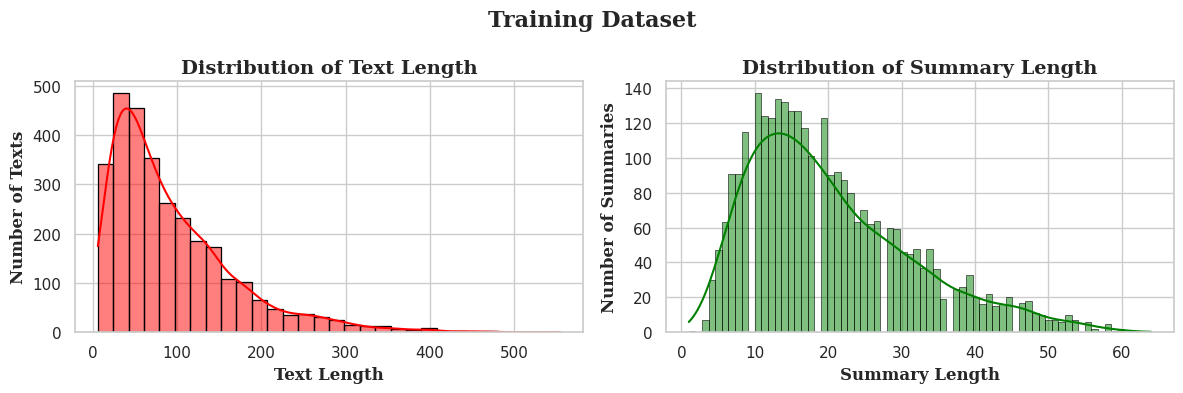

In [ ]:
# Calculate the lengths of the columns
df_train['text_length'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 3 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_train, x='text_length', bins=30, kde=True, edgecolor='black', color='red', ax=axes[0])
axes[0].set_title('Distribution of Text Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Texts', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_train, x='summary_length', bins=70, kde=True, edgecolor='black', color='green', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of Summaries', fontdict=font_label)


# Set a title for the set of subplots
plt.suptitle('Training Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Train Dataset**

In [ ]:
# Tokenize 'text' and 'summary' columns to count unique words
text_words = ' '.join(df_train['text']).split()
summary_words = ' '.join(df_train['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

Number of unique words in 'text': 19436
Number of unique words in 'summary': 8934


# **Loading Test Dataset**

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/english_summary_test.csv')
df_test.head()

,text,summary
0,LG where are U Vic coming LG ok Vic we're near...,LG is going to see Vic and say hi to Jean
1,Mark Do you already have this CD Ann Not yet A...,Ann is waiting for Kate to deliver this CD
2,Tristan I decided to go on a cruise with my pa...,Tristan is going for a cruise around Hawaii wi...
3,"Joan Hello dear, didn't see you in church toda...",Jean didn't come to church today due to her ba...
4,Helen Is this Andy from Celtic Leisure Not sur...,Helen is interested in swimming lessons at Cel...


# **Checking NaN values in Test dataset**

In [ ]:
# Check for NaN values in df_train
nan_count = df_test.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of Text and Summary Length of Testing Dataset**

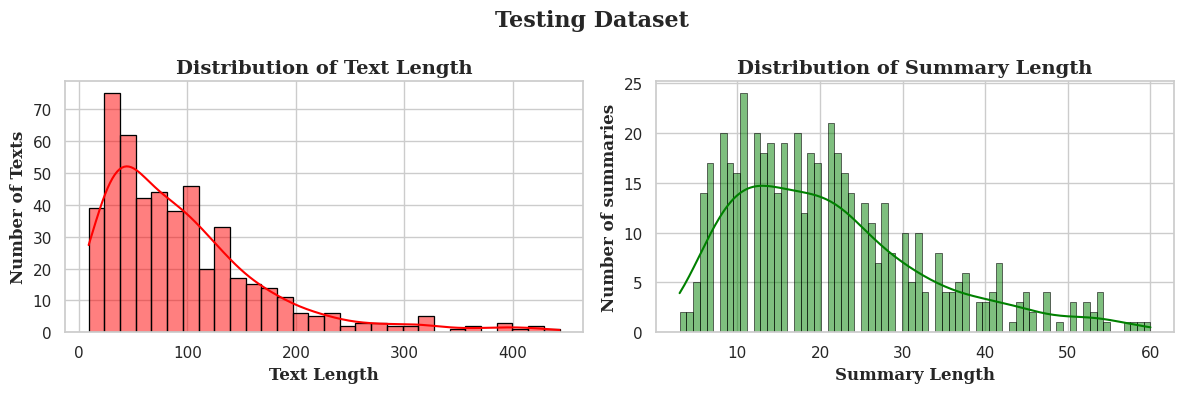

In [ ]:
# Calculate the lengths of the columns
df_test['text_length'] = df_test['text'].apply(lambda x: len(str(x).split()))
df_test['summary_length'] = df_test['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_test, x='text_length', bins=30, kde=True, edgecolor='black', color='red', ax=axes[0])
axes[0].set_title('Distribution of Text Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Texts', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_test, x='summary_length', bins=70, kde=True, edgecolor='black', color='green', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of summaries', fontdict=font_label)



# Set a title for the set of subplots
plt.suptitle('Testing Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Test Dataset**

In [ ]:
# Tokenize 'text' and 'passage' columns to count unique words
text_words = ' '.join(df_test['text']).split()
summary_words = ' '.join(df_test['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

Number of unique words in 'text': 6692
Number of unique words in 'summary': 2942


# **Validation dataset**

In [ ]:
df_validation = pd.read_csv('/content/drive/MyDrive/english_summary_validation.csv')
df_validation.head()

,text,summary
0,"Logan So what happens now Amelia They vote, I ...",Logan and Amelia discuss politics and Brexit L...
1,"Valerie Hello everyone, Uma is leaving soon so...",Cam decided to give Uma a cake and kokedama cl...
2,"Harry Hey, Todd and I are going snowboarding t...",Ian will join Harry and Todd on a snowboarding...
3,Samuel I want to watch Polish cinema but I don...,Samuel wants to watch some Polish movies Micha...
4,Nelly you know that Audrey went vegan Kate shu...,"Nelly, Kate and Ruth's friend, Audrey, has rec..."


# **Checking NaN values in validation dataset**

In [ ]:
# Check for NaN values in df_train
nan_count = df_validation.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of Text and Summary Length of Validation Dataset**

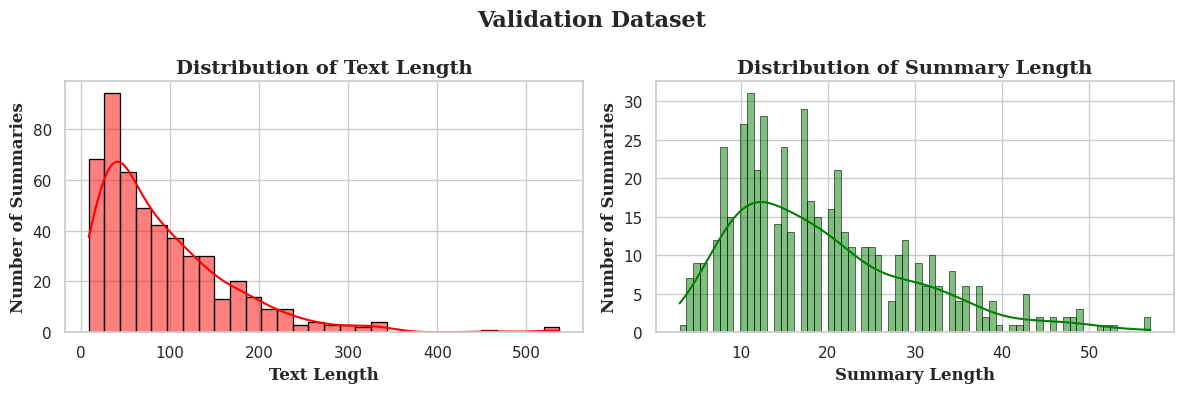

In [ ]:
# Calculate the lengths of the columns
df_validation['text_length'] = df_validation['text'].apply(lambda x: len(str(x).split()))
df_validation['summary_length'] = df_validation['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_validation, x='text_length', bins=30, kde=True, edgecolor='black', color='red', ax=axes[0])
axes[0].set_title('Distribution of Text Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Summaries', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_validation, x='summary_length', bins=70, kde=True, edgecolor='black', color='green', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of Summaries', fontdict=font_label)

# Set a title for the set of subplots
plt.suptitle('Validation Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Validation Dataset**

In [ ]:
# Tokenize 'text' and 'passage' columns to count unique words
text_words = ' '.join(df_validation['text']).split()
summary_words = ' '.join(df_validation['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

Number of unique words in 'text': 6584
Number of unique words in 'summary': 2698


# **Checking length of the datasets**

In [ ]:
print("Train Dataset Length: ",len(df_train))
print("Test Dataset Length: ",len(df_test))
print("Validation Dataset Length: ",len(df_validation))

Train Dataset Length:  3000
Test Dataset Length:  500
Validation Dataset Length:  500


# **Installing Necesary Libraries**

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-fmkzjs9w
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-fmkzjs9w
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6857 sha256=74789956eaafcd9cfedcc9984c4002d762a19e268f79b6f918d6f938d8a26335
  Stored in directory: /tmp/pip-ephem-wheel-cache-fqyj3vy0/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186457 sha256=85d9ce775939b9cd30956d30d0bbd26b0f5f0f7

In [ ]:
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!pip install torch

In [ ]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
!transformers-cli cache clear

2023-11-18 06:54:21.255936: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 06:54:21.256013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 06:54:21.256065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 06:54:24.520826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: argument {convert,download,env,run,serve,login,whoami,logout,repo,add-new-model,add-new-model-like,lfs-enable-largefiles,lfs-multipart-upload,pt-to-tf}: invalid choi

In [ ]:
!pip install transformers==4.10.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 47.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [ ]:
!pip install accelerate==0.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.24.1
    Uninstalling accelerate-0.24.1:
      Successfully uninstalled accelerate-0.24.1


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install --upgrade transformers

# **Apply normalization to the datasets**

In [ ]:
from normalizer import normalize
# Apply normalization to the datasets
df_train['text'] = df_train['text'].apply(normalize)
df_train['summary'] = df_train['summary'].apply(normalize)

df_test['text'] = df_test['text'].apply(normalize)
df_test['summary'] = df_test['summary'].apply(normalize)

df_validation['text'] = df_validation['text'].apply(normalize)
df_validation['summary'] = df_validation['summary'].apply(normalize)

# **T5 Model and Its Tokenizer**

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
#T5 comes in different sizes: t5-small , t5-base, t5-large, t5-3b, t5-11b.
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# **Custom dataset class**

In [ ]:
from torch.utils.data import Dataset, DataLoader

class EnglishSummaryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=520):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        summary = self.data.iloc[idx]['summary']


        # Tokenize text
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize summary
        tokenized_summary = self.tokenizer(
            summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process tokenized answer labels
        labels = tokenized_summary['input_ids'].squeeze()
        attention_mask_labels = tokenized_summary['attention_mask'].squeeze()

        # Ignore padded tokens during training
        labels[attention_mask_labels == 0] = -100

        # Handle cases where the input sequence is longer than max_length
        if inputs['input_ids'].shape[1] > self.max_length:
            inputs['input_ids'] = inputs['input_ids'][:, :self.max_length]
            inputs['attention_mask'] = inputs['attention_mask'][:, :self.max_length]
            attention_mask_labels = attention_mask_labels[:self.max_length]

        # Ensuring labels and attention_mask_labels have the same length
        labels = labels[:self.max_length]

        # Using .squeeze() on labels
        labels = labels.squeeze()

        # Return as dictionaries
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels,

        }


# **Create datasets and data loaders**

In [ ]:
train_dataset = EnglishSummaryDataset(df_train, tokenizer)
validation_dataset = EnglishSummaryDataset(df_validation, tokenizer)
test_dataset = EnglishSummaryDataset(df_test, tokenizer)

train_dataloader = DataLoader(train_dataset , batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset , batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset , batch_size=10, shuffle=False)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

# **Train Dataset Encoding Printing: text, summary (input_ids,attention_mask)**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([29467,   213,    19,    82,  3960,     3, 12963,  5424,   122,     9,
         1077,    16,     8, 18876, 29467,    27,  2299,  6531,  5424,   122,
            9,   150,   800,  8032, 29467,     3,     2, 11966,   122,    99,
         3155,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

# **Validation Dataset Encoding: text, summary (input_ids,attention_mask)**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in validation_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([22227,   264,   125,  2906,   230,   736, 13240,   328,  2902,     6,
           27,  3382, 22227,    27,   987,   250,    13,   175,  1281,  1867,
          378,   469,    94,   744,    31,    17,  1345,  1465,   736, 13240,
         9428,    81,    48,  2993,  1465, 22227,    94,    31,     7,     8,
         1653,     7,  7021,    24,    31,     7,     8,   682,   269,   230,
          736, 13240,  1610,    51,     7,    12,    36, 22227,   465,     6,
           34,    19,     6,   250,    79,    33,  2145,    34,    19,    29,
           31,    17,  1281,    12,  7189,   406,   430,  1653,     7,  2791,
           42,   424,   736, 13240,  1610,     6,   149,    54,    25,    36,
          417,   125,   959,   845,   269,   230, 22227,    27,    31,    51,
          131,  1183,   125,     8,  1506,   845,   736, 13240,  1699,  1050,
         1506, 23365, 22227,  2432,     6,   269, 22227,    94,    31,     7,
            8,  7262,  4947,    24,    31,     7,    

# **Test Dataset Encoding: text, summary (input_ids,attention_mask)**


In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([13444,   213,    33,   412, 12060,  1107, 13444,     3,  1825, 12060,
           62,    31,    60,  1084,    39,  7788, 13444, 15315,    44,     8,
         2068,  1367, 12060, 14583,    21,   178,    44,   954,  1109,  1063,
           31,     7, 13444,     3,  1825, 12060,    62,    31,    60,    44,
          234,    28,     8, 14590, 12060,   373,    44,   234, 13444,     3,
           63,    15,   102, 12060,    62,    31,    60,  3140, 13444,  2794,
           21,     3,    76, 12060, 23601,    95,    12,   497, 21820,    12,
            3, 26459, 13444,   125, 12060,  3966,    19,   270,   216,    31,
          195,    36,  1095,    12,   217,    25, 13268,   651,    95, 13444,
         1107, 12060,  1399,    27,    31,   195,   817,   376,    12,  1749,
           21,    25, 13444,     3,    23,    31,   195,    36,   132,    16,
          335,  3519, 12060,  8872,    62,    31,   195,  1749,    21,    25,
        13444,   217,     3,    76,  1116, 16497,    

# **Train Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: Laura But I don't know if I would like to miss such an amazing opportunity Kate We talk a lot about it Tbh it was hard for both of us Kate ed Laura Do you have any school exchanges coming up Kate Sadly no Kate There was one for the USA but I didn't got in there Kate Bc of some stupid opinions from my teachers Laura Laura I'm sorry for you Kate And did Lennart get that basketball scholarship to the USA Laura He didn't want to Kate O Kate Shock Laura That's quite difficult Laura It's bc he doesn't want to leave his home for a year or longer so Kate Somehow it's understandable Kate It must have been a hard decision Laura Yes indeed Laura But he was sure what he was doing Kate That's ok
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 

# **Validation Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in validation_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: Logan So what happens now Amelia They vote, I guess Logan I ask because of these legal advice things today It doesn't sound positive Amelia Nothing about this sounds positive Logan It's the customs union that's the problem right now Amelia Seems to be Logan No, it is, because they are saying it isn't legal to exit without another customs agreement or something Amelia See, how can you be sure what anything says right now Logan I'm just reading what the news says Amelia Fake news LOL Logan Um, right Logan It's the Irish border that's the problem Ireland is staying in the EU so there has to be a border Amelia Ah, and they don't want a hard border Logan No Makes everything more complicated and difficult Amelia But this is all lawyerspeak and legalese Logan Yes, but all lawyers do is give a frank opinion Amelia What does PM say Logan She's insistent that there has to be a backstop for NI and the border Amelia Well, then Logan Some backtracking there, but all in all an ho

# **Test Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)


    # Break out of the loop after processing the first batch
    break


Decoded Input Text: LG where are U Vic coming LG ok Vic we're near your cabin LG arriving at the letter box Vic Wait for us at maminou's LG ok Vic we're at home with the tenant Vic always at home LG yep Vic we're leaving LG waiting for u Vic hurry up to say hello to jean LG what Vic Jean is here He'll be happy to see you Hurry up LG coming Vic fine I'll tell him to wait for you LG i'll be there in 10 min Vic Ok we'll wait for you LG see u soon lol
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# **Training Arguments**

In [ ]:
from transformers import TrainingArguments
from torch.optim import AdamW


# Create a custom optimizer using torch.optim.AdamW
custom_optimizer = AdamW(
    model.parameters(),
    lr=1e-3,  # Learning rate
    eps=1e-8,  # Epsilon value to prevent division by zero
    weight_decay=0.01,  # Weight decay (L2 regularization)
)

# Define the TrainingArguments for question answering
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/English_Summary/T5_English_Summary',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 small batches
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    save_steps=500,
    learning_rate=1e-3,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine_with_restarts",  # Setting the learning rate scheduler type
    warmup_steps=100,  # Number of warmup steps
    weight_decay=0.01,  # Weight decay (L2 regularization)
    logging_dir='/content/drive/MyDrive/English_Summary/T5_English_Summary',  # Using the same directory for logs
    logging_steps=500,  # Log every 500 steps
)


# **Custom Data Collator for Summary Generation**
* A custom data collator for summary generation is used to handle the specific data formatting required for training models on question answering tasks. It facilitates the processing of input data into a format suitable for model training by performing tasks such as padding, truncation, and organizing inputs and labels for the Summary model.

In [ ]:
import torch
import torch.nn.functional as F
from transformers import DataCollatorForSeq2Seq

class CustomDataCollatorForSeq2Seq(DataCollatorForSeq2Seq):
    def __call__(self, features):
        batch = super().__call__(features)

        # Find the maximum length of labels in the batch
        max_label_length = max(feature["labels"].shape[-1] for feature in features)

        # Pad or truncate the "labels" arrays to have the same length
        batch["labels"] = torch.stack([
            F.pad(torch.as_tensor(feature["labels"]), (0, max_label_length - feature["labels"].shape[-1]), value=-100)
            for feature in features
        ])

        return batch




# Creating a data collator using the custom collator
data_collator = CustomDataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=520,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8  # Ensuring the sequence length is a multiple of 8 (adjust as needed)
)

# **Trainer**
* The trainer package provides utilities to write re-usable training scripts. The core idea is to use a trainer that implements a nested loop, where the outer loop runs the data collection steps and the inner loop the optimization steps.

In [ ]:
from transformers import Trainer
# Define the Trainer with the custom optimizer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=(custom_optimizer, None),  # Passing the custom optimizer here
)


# **Training Starts Here**

In [ ]:
# Fine-tune the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=375, training_loss=2.486187174479167, metrics={'train_runtime': 316.4743, 'train_samples_per_second': 9.479, 'train_steps_per_second': 1.185, 'total_flos': 412369551360000.0, 'train_loss': 2.486187174479167, 'epoch': 1.0})

# **Saving model and tokenizer**

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json')


('/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json/spiece.model',
 '/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json/added_tokens.json')

# **Loading trained model and tokenizer**

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the saved model
model = T5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Model.pt')

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('/content/drive/MyDrive/English_Summary/T5_English_Summary/English_Summary_T5_Tokenizer.json')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# **Evaluation Metrics Installing**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9dd03f1cdda75ffc41107279acf5b7d248e0d4bca94ebb2805c1eae6be7a9057
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.3 MB/s eta 0:00:00


# **Testing the model**

In [ ]:
decoded_predictions_batch = []
decoded_references_batch = []

# Loop through the test dataset and generate predictions
for batch in test_dataloader:
    inputs = batch['input_ids'].to('cuda')  # Move inputs to the 'cuda' device
    labels = batch['labels'].to('cuda')  # Move labels to the 'cuda' device

    # Ensuring the model, inputs, and labels are on the same device
    model = model.to(inputs.device)

    # Generating answers using our model
    with torch.no_grad():
        # Generating predictions
        predictions = model.generate(inputs, max_length=520, num_beams=4, early_stopping=True)

        # Decoding generated answers
        try:
            decoded_predictions_batch.extend(tokenizer.batch_decode(predictions.cpu(), skip_special_tokens=True))
        except Exception as e:
            print("Exception occurred during decoding (predictions):", e)


        # Decoding labels for references
        try:
            # Converting labels to a list of token IDs
            labels_list = labels.cpu()
             # Decoding each label sequence
            decoded_references_batch.extend([tokenizer.decode(ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True) for ids in labels_list])
        except Exception as e:
            print("Exception occurred during decoding (references):", e)



In [ ]:
print(decoded_predictions_batch)

["LG is waiting for LG to arrive at the letter box at maminou's LG will be there in 10 minutes", 'Ann is waiting for Kate to bring the CD to Mark', 'Tristan is going to visit the Russian Kamchatka and Alaska area this summer', "Jean didn't see her in church today, but he's in pain, but he's in pain, but he's in pain, but he's going to the Church Hall for coffees", 'Andy and Caitlin are going to enquire about swimming lessons in July', "Shawn has heard Slipknot's new single yet", 'Morton found a cheap flight to dubai for six nights', "Sara hasn't seen Alicia today at class because her parents are getting divorced", 'Justin and Kevin are going to watch TV and watch commercials Justin has to turn off his dishwasher', "Lindsey and Omarosa don't have much work to do this week", 'Tom will meet with Tom at 720pm on Stokes Croft to discuss the project Tom will meet with Tom at 720pm on Stokes Croft', "Helen's mum called Adrien but he's fine, but she wants to stay with him", 'Lucy and Tedd have

In [ ]:
print(len(decoded_predictions_batch))

500


In [ ]:
print( decoded_references_batch)

['LG is going to see Vic and say hi to Jean', 'Ann is waiting for Kate to deliver this CD', 'Tristan is going for a cruise around Hawaii with his parents in the summer He will cruise also around Kamchatka and Alaska area', "Jean didn't come to church today due to her back pain Jean takes painkillers for it Jean and Joan were nurses for 40 years Harry is considering moving to Scotland for work Stella visited Jean after church and overstayed her welcome as she tends to do Joan's brother is a widower", "Helen is interested in swimming lessons at Celtic Leisure for her daughter Caitlin Caitlin is 6 Andy, a swimming coach, looks for a course for Caitlin July is all booked up, but there is a beginner's course during the first 3 weeks of August It costs £150 It's a bit more than Helen expected", "Shawn shares Slipknot's new music video with Greg", "Morton has found cheap flights to Dubai and they're flying there next Thursday for six nights He hasn't checked the hotels yet He has to talk to V

In [ ]:
print(len(decoded_references_batch))

500


# **Metrics Loading**

In [ ]:
from evaluate import load

# Loading the evaluation metric for Character Error Rate (CER) and Word Error Rate (WER) and Exact Match(em)
cer_metric = load("cer")
wer_metric = load("wer")
exact_match_metric = load("exact_match")

# Loading BLEU and METEOR metrics
bleu_metric = load("bleu")
meteor = load('meteor')

# Calculating Character Error Rate (CER), Word Error Rate (WER) and Exact Match (EM)
results_CER = cer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_WER = wer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_em = exact_match_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

# Calculating Bilingual Evaluation Understudy (BLEU) , Recall-Oriented Understudy for Gisting Evaluation (ROUGE) and METEOR(M)
results_bleu = bleu_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_met = meteor.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
print("Character Error Rate for Bangla Summary:", results_CER)
print("Word Error Rate for Bangla Summary:",results_WER)
print("Exact Match for Bangla Summary:",results_em)
print("BLEU Score for Bangla Summary:",results_bleu)
print("METEOR for Bangla Summary:",results_met)

Character Error Rate for Bangla Summary: 0.7234395335983883
Word Error Rate for Bangla Summary: 0.8449399981101767
Exact Match for Bangla Summary: {'exact_match': 0.002}
BLEU Score for Bangla Summary: {'bleu': 0.06053443100267818, 'precisions': [0.518249570036308, 0.22522712867103317, 0.12189936215450035, 0.06857755156710421], 'brevity_penalty': 0.34250482960197387, 'length_ratio': 0.4827490774907749, 'translation_length': 5233, 'reference_length': 10840}
METEOR for Bangla Summary: {'meteor': 0.2623042171750729}


In [ ]:
!pip install rouge-score

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00


# **ROUGE Score Calculation**

In [ ]:
from rouge_score import rouge_scorer
from unidecode import unidecode

# Initialize the Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

# Preprocess the text
def preprocess_text(text):
    text = unidecode(text)
    tokens = text.split()
    return ' '.join(tokens)

# Calculate scores for each pair of predictions and references
rouge1_f1_scores = []
rouge1_precision_scores = []
rouge1_recall_scores = []
rouge2_f1_scores = []
rouge2_precision_scores = []
rouge2_recall_scores = []
rougeL_f1_scores = []
rougeL_precision_scores = []
rougeL_recall_scores = []

for ref, pred in zip(decoded_references_batch, decoded_predictions_batch):
    candidate_summary = preprocess_text(pred)
    reference_summary = preprocess_text(' '.join(ref))
    scores = scorer.score(reference_summary, candidate_summary)

    rouge1_f1_scores.append(scores['rouge1'].fmeasure)
    rouge1_precision_scores.append(scores['rouge1'].precision)
    rouge1_recall_scores.append(scores['rouge1'].recall)
    rouge2_f1_scores.append(scores['rouge2'].fmeasure)
    rouge2_precision_scores.append(scores['rouge2'].precision)
    rouge2_recall_scores.append(scores['rouge2'].recall)
    rougeL_f1_scores.append(scores['rougeL'].fmeasure)
    rougeL_precision_scores.append(scores['rougeL'].precision)
    rougeL_recall_scores.append(scores['rougeL'].recall)

# Calculate the average scores
avg_rouge1_f1 = sum(rouge1_f1_scores) / len(rouge1_f1_scores)
avg_rouge1_precision = sum(rouge1_precision_scores) / len(rouge1_precision_scores)
avg_rouge1_recall = sum(rouge1_recall_scores) / len(rouge1_recall_scores)
avg_rouge2_f1 = sum(rouge2_f1_scores) / len(rouge2_f1_scores)
avg_rouge2_precision = sum(rouge2_precision_scores) / len(rouge2_precision_scores)
avg_rouge2_recall = sum(rouge2_recall_scores) / len(rouge2_recall_scores)
avg_rougeL_f1 = sum(rougeL_f1_scores) / len(rougeL_f1_scores)
avg_rougeL_precision = sum(rougeL_precision_scores) / len(rougeL_precision_scores)
avg_rougeL_recall = sum(rougeL_recall_scores) / len(rougeL_recall_scores)

# Print the average scores
print("Average Rouge-1 F1 Score:", avg_rouge1_f1)
print("Average Rouge-1 Precision:", avg_rouge1_precision)
print("Average Rouge-1 Recall:", avg_rouge1_recall)

print("Average Rouge-2 F1 Score:", avg_rouge2_f1)
print("Average Rouge-2 Precision:", avg_rouge2_precision)
print("Average Rouge-2 Recall:", avg_rouge2_recall)

print("Average Rouge-L F1 Score:", avg_rougeL_f1)
print("Average Rouge-L Precision:", avg_rougeL_precision)
print("Average Rouge-L Recall:", avg_rougeL_recall)


Average Rouge-1 F1 Score: 0.014640774553895867
Average Rouge-1 Precision: 0.05878503514176752
Average Rouge-1 Recall: 0.00867280009910538
Average Rouge-2 F1 Score: 3.0075187969924815e-05
Average Rouge-2 Precision: 8.333333333333333e-05
Average Rouge-2 Recall: 1.834862385321101e-05
Average Rouge-L F1 Score: 0.014519562432683746
Average Rouge-L Precision: 0.05853503514176752
Average Rouge-L Recall: 0.00859280009910538


# **Saving results to a csv file**

In [ ]:
# Create a DataFrame to store translations
generated_summary_df = pd.DataFrame({
    'text': df_test['text'],  # Assuming 'test_data' contains our test dataset
    'Reference_Summary': decoded_references_batch,
    'Generated_Summary': decoded_predictions_batch
})

# Save translations to a CSV file
generated_summary_df.to_csv("/content/drive/MyDrive/English_Summary/T5_English_Summary/T5_generated_answers.csv", index=False)


# **Word Information Lost Calculation**

In [ ]:
def calculate_word_information_lost(original_summary, generated_summary):
    # Tokenize the text into unique tokens
    original_tokens = set(original_summary.split())
    generated_tokens = set(generated_summary.split())

    # Calculate the number of unique tokens before and after processing
    num_original_tokens = len(original_tokens)
    num_generated_tokens = len(generated_tokens)

    # Calculate Word Information Lost (WIL)
    wil = 1 - (num_generated_tokens / num_original_tokens) if num_original_tokens != 0 else 0

    return wil

In [ ]:
WIL_df = pd.read_csv("/content/drive/MyDrive/English_Summary/T5_English_Summary/T5_generated_answers.csv")
WIL_df.head()

,text,Reference_Summary,Generated_Summary
0,LG where are U Vic coming LG ok Vic we're near...,LG is going to see Vic and say hi to Jean,LG is waiting for LG to arrive at the letter b...
1,Mark Do you already have this CD Ann Not yet A...,Ann is waiting for Kate to deliver this CD,Ann is waiting for Kate to bring the CD to Mark
2,Tristan I decided to go on a cruise with my pa...,Tristan is going for a cruise around Hawaii wi...,Tristan is going to visit the Russian Kamchatk...
3,"Joan Hello dear, didn't see you in church toda...",Jean didn't come to church today due to her ba...,"Jean didn't see her in church today, but he's ..."
4,Helen Is this Andy from Celtic Leisure Not sur...,Helen is interested in swimming lessons at Cel...,Andy and Caitlin are going to enquire about sw...


In [ ]:
# Apply the function row-wise using apply along with axis=1
WIL_df['Word_Information_Lost'] = WIL_df.apply(lambda row: calculate_word_information_lost(row['Reference_Summary'], row['Generated_Summary']), axis=1)

# Display the resulting DataFrame with the Word Information Lost column
WIL_df.head()


,text,Reference_Summary,Generated_Summary,Word_Information_Lost
0,LG where are U Vic coming LG ok Vic we're near...,LG is going to see Vic and say hi to Jean,LG is waiting for LG to arrive at the letter b...,-0.700000
1,Mark Do you already have this CD Ann Not yet A...,Ann is waiting for Kate to deliver this CD,Ann is waiting for Kate to bring the CD to Mark,-0.111111
2,Tristan I decided to go on a cruise with my pa...,Tristan is going for a cruise around Hawaii wi...,Tristan is going to visit the Russian Kamchatk...,0.380952
3,"Joan Hello dear, didn't see you in church toda...",Jean didn't come to church today due to her ba...,"Jean didn't see her in church today, but he's ...",0.564103
4,Helen Is this Andy from Celtic Leisure Not sur...,Helen is interested in swimming lessons at Cel...,Andy and Caitlin are going to enquire about sw...,0.707317


In [ ]:
# Calculate the mean Word Information Lost across all rows
mean_wil = WIL_df['Word_Information_Lost'].mean()
print(f"Mean Word Information Lost (WIL): {mean_wil:.2f}")

Mean Word Information Lost (WIL): 0.38
